In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from landaupy import langauss
from landaupy import landau
from scipy.optimize import curve_fit
from scipy.optimize import OptimizeWarning
from tqdm import tqdm
import warnings
from scipy.stats import chisquare
import sys
sys.path.append("../src")
from event_selections import *
from scipy.integrate import quad
from scipy.integrate import IntegrationWarning
from scipy.stats import zscore
import scipy.signal as sig

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

warnings.simplefilter("error", OptimizeWarning)
warnings.simplefilter("error", IntegrationWarning)
np.seterr(all='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [3]:
c_folder="../../data/calibration"
d_folder="../../data/runData"
r_n=305
pulsed=True
p_folder="../../plots/run_"+str(r_n)

In [4]:
pedestals=pd.read_csv(c_folder+"/pedestals.csv", sep=',')
pedestals=pedestals.drop(columns=['pedestal_per_time_sample', 'mean'])

In [5]:
#mips=pd.read_csv("mip.csv", sep=',')
#mips=mips.drop(columns=['eta', 'sigma', 'A'])

In [6]:
# can and should be improved
def drop_empty(df):
    data=[]

    layers=np.arange(1,20)
    strips=np.arange(0,12)
    
    for layer in layers:
        for strip in strips:
            el=choose_bar(df,layer,strip)
            peds=choose_bar(pedestals,layer,strip)
            #mip=choose_bar(mips, layer, strip)

            if not peds.empty: # need to check whether the strip exists 
                el=el[el["adc_sum_end0"]>(peds.iloc[0,-2]+5*peds.iloc[0,-1])] 
                el=el[el["adc_sum_end1"]>(peds.iloc[1,-2]+5*peds.iloc[1,-1])] 
                
                el=el[el["adc_max_end0"]!=1023]
                el.loc[:,"adc_sum_end0"]-=peds.iloc[0,-2]
                
                el=el[el["adc_max_end1"]!=1023]
                el.loc[:,"adc_sum_end1"]-=peds.iloc[1,-2]
                
                miniped=peds.iloc[0,-2]/8
                miniped1=peds.iloc[1,-2]/8
                
                el.loc[:,"adc_0_end0"]-=miniped
                el.loc[:,"adc_1_end0"]-=miniped
                el.loc[:,"adc_2_end0"]-=miniped
                el.loc[:,"adc_3_end0"]-=miniped
                el.loc[:,"adc_4_end0"]-=miniped
                el.loc[:,"adc_5_end0"]-=miniped
                el.loc[:,"adc_6_end0"]-=miniped
                el.loc[:,"adc_7_end0"]-=miniped

                el.loc[:,"adc_0_end1"]-=miniped1
                el.loc[:,"adc_1_end1"]-=miniped1
                el.loc[:,"adc_2_end1"]-=miniped1
                el.loc[:,"adc_3_end1"]-=miniped1
                el.loc[:,"adc_4_end1"]-=miniped1
                el.loc[:,"adc_5_end1"]-=miniped1
                el.loc[:,"adc_6_end1"]-=miniped1
                el.loc[:,"adc_7_end1"]-=miniped1
                
                data.extend(el.values.tolist())
                
    names=list(df.columns)

    df_s=pd.DataFrame(data, columns=names)
    
    return df_s

In [7]:
def langau(x,A,x_mpv,xi,sigma):
    return A*langauss.pdf(x=x, landau_x_mpv=x_mpv,landau_xi=xi,gauss_sigma=sigma)

In [8]:
def landau_fit(x,A,x_mpv,xi):
    return A*landau.pdf(x=x,x_mpv=x_mpv, xi=xi)

In [9]:
def cs(n, y):
    return chisquare(n, np.sum(n)/np.sum(y) * y)

In [10]:
def FWHM(X,Y):
    half_max = max(Y) / 2.
    #find when function crosses line half_max (when sign of diff flips)
    #take the 'derivative' of signum(half_max - Y[])
    d = np.sign(half_max - np.array(Y[0:-1])) - np.sign(half_max - np.array(Y[1:]))
    #plot(X[0:len(d)],d) #if you are interested
    #find the left and right most indexes
    left_idx = np.where(d > 0)[0]
    right_idx = np.where(d < 0)[-1]
    return X[right_idx] - X[left_idx] #return the difference (full width)

In [11]:
electron=pd.read_csv(d_folder+"/run_305_pulse.csv", sep=',')
electron=electron.drop(columns=['tot_end0', 'toa_end0','tot_end1', 'toa_end1',
                                'pf_spill', 'adc_mean_end0', 'adc_mean_end1', 'pf_ticks'])

In [12]:
#bs_pulses, bs_num=select_faulty_data(electron,pedestals)

In [13]:
electron=electron.astype(float)

In [14]:
electron=drop_empty(electron)

In [15]:
bs_pulses, bs_num=select_faulty_data(electron,pedestals)

filtering faulty events...
number of faulty events:  22087


In [16]:
electron=electron[~electron.index.isin(bs_pulses)].reset_index()

In [17]:
electron=electron.drop(columns=["index"])

In [18]:
# different drop_empty needed for this to work!!!!!!!
def make_fit(row):
    time_steps=np.arange(0,8)
    inter_steps=np.arange(0,8,0.5)
    data=row.iloc[3:11]
    outpar=[]
    line=[row["layer"], row["strip"], row["adc_sum_end0"], row["adc_max_end0"]]
    error=np.full(6,np.nan)
    with warnings.catch_warnings():
        try:
            param, _ =curve_fit(landau_fit,time_steps, data, p0=[200,2.0,2], maxfev=800)
            if param[0]>5:
                
                observed=landau_fit(inter_steps, *param)
                expected=np.interp(inter_steps, time_steps, np.array(data))
                _, pval=cs(observed, expected)
                if pval<1e-25 and pval!=0:
                    line.extend(error)
                    
                else:
                    # return row 
                    integral, _ = quad(landau_fit, 0,7, tuple(param), limit=100)
                    true_amp=max(landau_fit(np.arange(0,8,0.01),*param))
                    width=FWHM(np.arange(0,8,0.01),landau_fit(np.arange(0,8,0.01), *param))
                    line.extend(param)
                    line.append(integral)
                    line.append(true_amp)
                    line.extend(width)
                    
        except: 
            line.extend(error)
    return line

In [19]:
n=100000
mini_df=electron.head(n)

In [20]:
tqdm.pandas() 
data=mini_df.progress_apply(make_fit, axis=1).values.tolist()
# data=electron.progress_apply(make_fit, axis=1).values.tolist()

100%|███████████████████████████████████| 100000/100000 [36:43<00:00, 45.38it/s]


In [21]:
param_df=pd.DataFrame(data, columns=["layer", "strip", "adc_sum", "adc_max",
                                     "A", "landau_x_mpv", "landau_xi", #"gauss_sigma", 
                                     "fit_integral", "fit_amplitude", "fit_width"])

In [22]:
param_df=param_df.dropna(axis=0)
remain=len(param_df)
print("Failed fits: "+str(round(100*(n-remain)/n,4))+" %")

Failed fits: 25.232 %


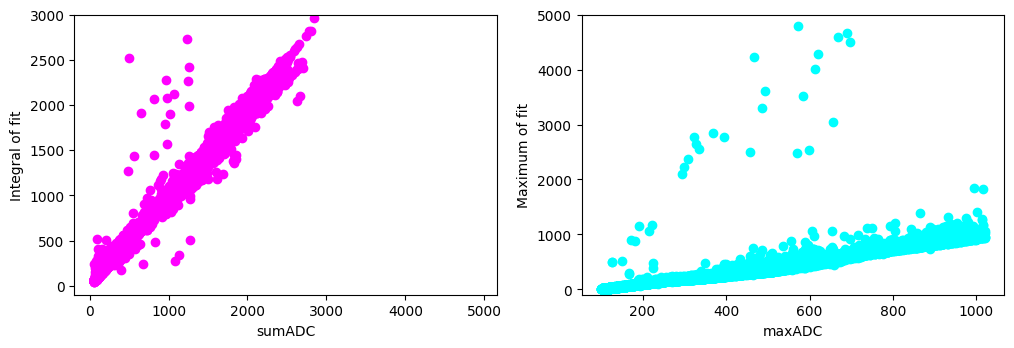

In [26]:
plt.rcParams['figure.figsize']=(12,8)

plt.subplot(2,2,1)
plt.scatter(param_df['adc_sum'], param_df['fit_integral'], c="magenta")
plt.ylabel('Integral of fit')
plt.xlabel('sumADC')
plt.ylim(-100,3000)

plt.subplot(2,2,2)
plt.scatter(param_df['adc_max'], param_df['fit_amplitude'], c="cyan")
plt.ylabel('Maximum of fit')
plt.xlabel('maxADC')
plt.ylim(-100,5000)

#plt.savefig(p_folder+"/after_more_precision.png", bbox_inches='tight')
plt.show()

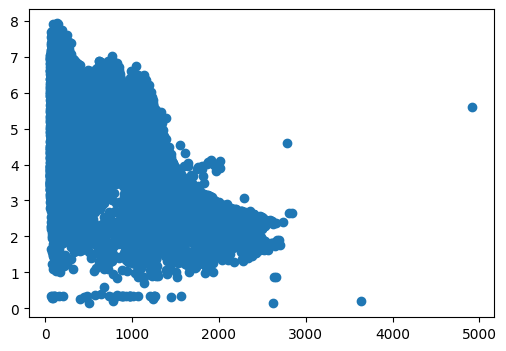

In [27]:
plt.rcParams["figure.figsize"]=(6,4)
plt.scatter(param_df['adc_sum'], param_df['fit_width'])

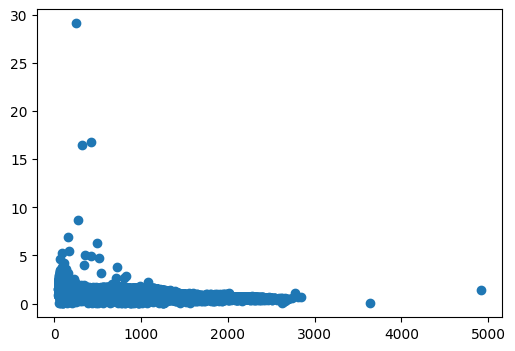

In [40]:
plt.scatter(param_df['adc_sum'], param_df['landau_xi'])

In [28]:
filtered_param=param_df.copy()
filtered_param=filtered_param[np.abs(zscore(filtered_param['landau_x_mpv'])) < 3]
filtered_param=filtered_param[np.abs(zscore(filtered_param['landau_xi'])) < 3]
filtered_param=filtered_param[np.abs(zscore(filtered_param['A'])) < 3]
good_fit_n=len(filtered_param)

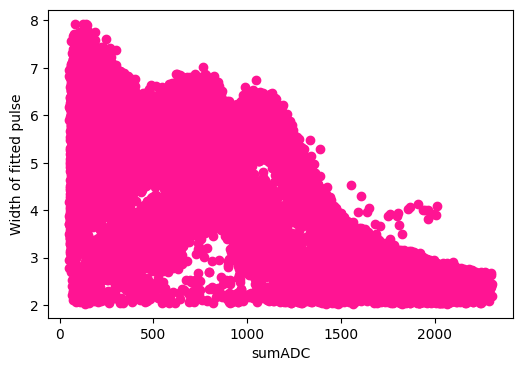

In [32]:
plt.scatter(filtered_param['adc_sum'], filtered_param['fit_width'], c="deeppink")
plt.ylabel("Width of fitted pulse")
plt.xlabel("sumADC")
plt.savefig(p_folder+"/misbehaving_width.png", bbox_inches='tight')

In [26]:
print("A_max: " +str(round(filtered_param['A'].max(),2)))
print("A_min: " +str(round(filtered_param['A'].min(),2)))
print("\n")
print("xi_max: " +str(round(filtered_param['landau_xi'].max(),2)))
print("xi_min: " +str(round(filtered_param['landau_xi'].min(),2)))
print("\n")
print("x0_max: " +str(round(filtered_param['landau_x_mpv'].max(),2)))
print("x0_min: " +str(round(filtered_param['landau_x_mpv'].min(),2)))

A_max: 2649.37
A_min: 65.68


xi_max: 2.12
xi_min: 0.6


x0_max: 4.84
x0_min: 1.25
